# Domain Adaptation

In [1]:
from dataset import Dataset, build_FIVES_dataloaders, build_hsi_dataloader, HSIDataset
from torch.utils.data import DataLoader
import torch

trainloader_source, validationloader_source, testloader_source = (
    build_FIVES_dataloaders(batch_size=16, width=224, height=224, cropped=True)
)

window=(500, 600)
trainloader_target = build_hsi_dataloader(
    batch_size=8,
    train_split=1,
    val_split=0,
    test_split=0,
    window=window,
    exclude_labeled_data=True,
)[0]

path = "./data/helicoid_with_labels"
testset = HSIDataset(path, with_gt=True, window=window)
testset.normalize_dataset()
testloader_target = DataLoader(testset, batch_size=1, shuffle=False)
print(len(trainloader_target), len(testloader_target))

Number of samples in the training set: 640, validation set: 60
Number of samples in the test set: 200
4 5


## Evaluation of Model without Domain Adaptation on Target Testset

### Transfer Learning

In [3]:
from segmentation_util import evaluate_model, build_segmentation_model
import torch
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = build_segmentation_model('resnet50', 'Unet', device, in_channels=1)

evaluate_model(
    model, testloader_target, device, with_wandb=False
)

Precision: nan, Recall: 0.0239, F1 Score: 0.0410, Dice Score: 0.0410, Accuracy: 0.7850


(tensor(nan, device='cuda:3'),
 tensor(0.0239, device='cuda:3'),
 tensor(0.0410, device='cuda:3'),
 tensor(0.7850, device='cuda:3'),
 tensor(0.0410, device='cuda:3'))

### Ensemble Model

In [3]:
from HSI_Net import SegmentationModelWithWindowing
from segmentation_util import build_segmentation_model, evaluate_model
from ensemble_model import EnsembleModelAverage
import segmentation_models_pytorch as smp
import torch

path = "./data/helicoid_with_labels"
testset = HSIDataset(path, with_gt=True)
testset.normalize_dataset()
testloader_target = DataLoader(testset, batch_size=1, shuffle=False)

encoder = 'timm-regnetx_320'
architecture = 'Linknet'
device = ('cuda:3' if torch.cuda.is_available() else 'cpu')

segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel.load_state_dict(torch.load('./models/{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth'.format(architecture=architecture, encoder=encoder)))
segmenter_single_channel.eval()

window1 = (400, 500)
window2 = (500, 600)
window3 = (600, 700)
window4 = (700, 800)
window5 = (800, 900)
window6 = (900, 1000)
window_full = (400, 1100)


model_windowing_400to500 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window1))
model_with_windowing_500to600 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window2))
model_windowing_600to700 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window3))
model_windowing_700to800 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window4))
model_windowing_800to900 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window5))
model_windowing_900to1000 = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window6))
model_window_full = SegmentationModelWithWindowing(segmenter_single_channel, window=testset.get_window_from_wavelengths(window_full))

model = EnsembleModelAverage([model_windowing_400to500, model_with_windowing_500to600, model_windowing_600to700, model_windowing_700to800, model_windowing_900to1000, model_window_full])
evaluate_model(model, testloader_target, device, with_wandb=False)

Precision: 0.5368, Recall: 0.2351, F1 Score: 0.3072, Dice Score: 0.3072, Accuracy: 0.8104


(tensor(0.5368, device='cuda:3'),
 tensor(0.2351, device='cuda:3'),
 tensor(0.3072, device='cuda:3'),
 tensor(0.8104, device='cuda:3'),
 tensor(0.3072, device='cuda:3'))

# Domain Adaptation Approaches:
## GRL domain adaptation

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Epoch 1, Batch 10/80, Total Loss: 68.4002, Segmentation Loss: 0.8864, Domain Loss Source: 0.0005, Domain Loss Target: 9.4123
Epoch 1, Batch 20/80, Total Loss: 4.1346, Segmentation Loss: 0.9007, Domain Loss Source: 0.0548, Domain Loss Target: 2.3684
Epoch 1, Batch 30/80, Total Loss: 3.4371, Segmentation Loss: 0.9175, Domain Loss Source: 0.2462, Domain Loss Target: 1.3618
Epoch 1, Batch 40/80, Total Loss: 3.6949, Segmentation Loss: 0.9478, Domain Loss Source: 0.6314, Domain Loss Target: 0.6760
Epoch 1, Batch 50/80, Total Loss: 2.2615, Segmentation Loss: 0.8755, Domain Loss Source: 0.6994, Domain Loss Target: 0.6914
Epoch 1, Batch 60/80, Total Loss: 2.2996, Segmentation Loss: 0.9212, Domain Loss Source: 0.7024, Domain Loss Target: 0.6982
Epoch 1, Batch 70/80, Total Loss: 2.2634, Segmentation Loss: 0.9111, Domain Loss Source: 0.6724, Domain Loss Target: 0.7183
Epoch 1, Batch 80/80, Total Loss: 2.2924, Segmentation Loss: 0.9217, Domain Loss Source: 0.6732, Domain Loss Target: 0.7135
Epoch 1

dice_score/source,▁▁▁▁▂▄▂▄▄█
dice_score/target,▆▇▇▇▇▁▇█▇▂
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,▂▁▁▁▁▃▂▃▃█
precision/target,▅▅▅▅▅▁▅█▅▃
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/loss,█▁▁▁▁▁▁▁▁▁


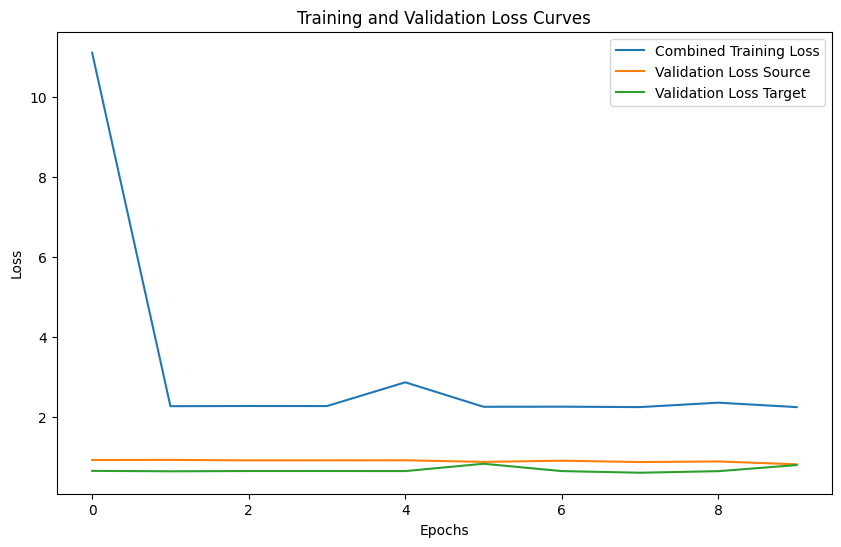

In [3]:
from segmentation_util import build_segmentation_model, build_criterion, build_optimizer
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from domain_adaptation_training import model_pipeline

encoder = "resnet50"
architecture = "Unet"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
lambda_param = 0.5
learning_rate = 0.0157
loss = "Dice"
epochs = 10


config = {
    "model": "GRL-{architecture}-{encoder}-window_{window[0]}-{window[1]}".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "lambda_param": lambda_param,
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "epochs": epochs,
    "loss": loss,
}

model, train_losses, val_losses_source, val_losses_target = model_pipeline(
    trainloader_source,
    validationloader_source,
    testloader_source,
    trainloader_target,
    testloader_target,
    config,
    project="domain-adaptation",
    device=device,
    batch_print=10,
    evaluate=True,
    with_overlays=True,
)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

## FADA:

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tim-mach (idp2024). Use `wandb login --relogin` to force relogin


Epoch 1, Batch 10/80, Total Loss: 6.1333, Segmentation Loss: 0.9407, Domain Loss Source: 1.5963, Domain Loss Target: 0.0662, Adversarial Loss Target: 0.0028
Epoch 1, Batch 20/80, Total Loss: 1.8207, Segmentation Loss: 0.8731, Domain Loss Source: 0.2474, Domain Loss Target: 0.5741, Adversarial Loss Target: 0.0004
Epoch 1, Batch 30/80, Total Loss: 1.8999, Segmentation Loss: 0.9344, Domain Loss Source: 0.7449, Domain Loss Target: 0.2040, Adversarial Loss Target: 0.0012
Epoch 1, Batch 40/80, Total Loss: 1.6958, Segmentation Loss: 0.9436, Domain Loss Source: 0.1587, Domain Loss Target: 0.8699, Adversarial Loss Target: 0.0003
Epoch 1, Batch 50/80, Total Loss: 1.6514, Segmentation Loss: 0.9683, Domain Loss Source: 0.5145, Domain Loss Target: 0.2515, Adversarial Loss Target: 0.0009
Epoch 1, Batch 60/80, Total Loss: 1.5638, Segmentation Loss: 0.8945, Domain Loss Source: 0.3338, Domain Loss Target: 0.2888, Adversarial Loss Target: 0.0007
Epoch 1, Batch 70/80, Total Loss: 1.5110, Segmentation Los

dice_score/source,▁▁▁▂▂▂▁▂▂█
dice_score/target,███▂██▂██▁
epoch,▁▂▃▃▄▅▆▆▇█
precision/source,▁▁▁▁▁▂▁▂▂█
precision/target,███▆██▃██▁
test/accuracy,▁
test/dice_score,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/loss,▇▁▁▁▁▁▁█▂▁


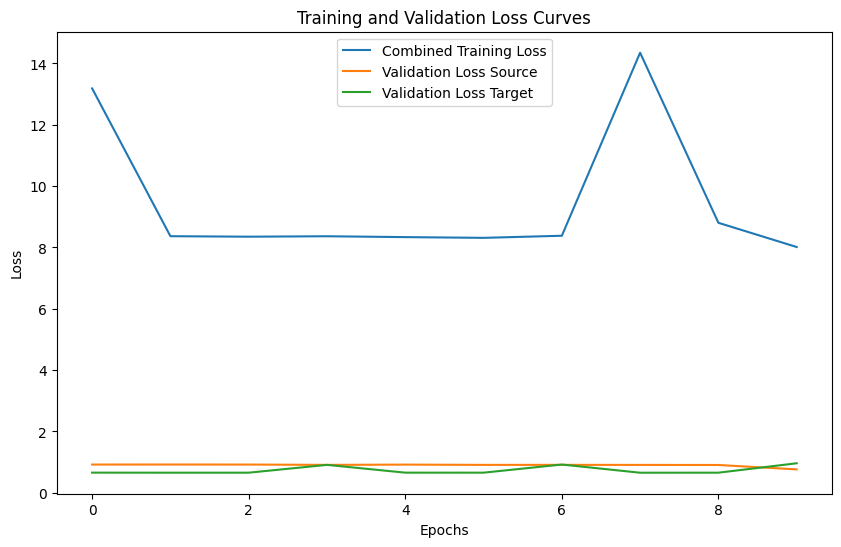

In [2]:
from segmentation_util import build_segmentation_model, build_criterion, build_optimizer
import matplotlib.pyplot as plt
from FADA.feature_extractor import FeatureExtractor
from FADA.classifier import Classifier
from FADA.train_FADA import model_pipeline

encoder = "resnet50"
architecture = "Unet"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
learning_rate = 0.01
epochs = 10
loss = "Dice"
learning_rate_fea = 0.01
learning_rate_cls = 0.01
learning_rate_dis = 0.001

config = {
    "model": "FADA-{architecture}-{encoder}-cropped-window_{window[0]}-{window[1]}".format(
        architecture=architecture, encoder=encoder, window=window
    ),
    "encoder": encoder,
    "architecture": architecture,
    "input_nc": 2048,
    "optimizer": "Adam",
    "batch_size_source": trainloader_source.batch_size,
    "batch_size_target": trainloader_target.batch_size,
    "learning_rate_fea": learning_rate_fea,
    "learning_rate_cls": learning_rate_cls,
    "learning_rate_dis": learning_rate_dis,
    "epochs": epochs,
    "seg_loss": loss,
}


model, train_losses, val_losses_source, val_losses_target = model_pipeline(
    trainloader_source,
    validationloader_source,
    testloader_source,
    trainloader_target,
    testloader_target,
    config,
    project="domain-adaptation",
    device=device,
    batch_print=10,
    evaluate=True,
    with_overlays=True,
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Combined Training Loss")
plt.plot(val_losses_source, label="Validation Loss Source")
plt.plot(val_losses_target, label="Validation Loss Target")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()